In [54]:
import random
import pickle
import numpy as np
from datasets import load_dataset, concatenate_datasets
import os
from chatgpt_eval import get_chatgpt_eval_news, get_chatgpt_eval_lfqa, get_chatgpt_eval_recipe


def shuffle_two_lists(l1, l2, indices=None, random_seed=None):
    random.seed(random_seed)
    if not indices:
        indices = list(range(len(l1)))
        random.shuffle(indices)    
    if len(indices) != len(l1):
        raise ValueError("The length of indices should be the same as the length of the lists")
    if len(l1) != len(l2):
        raise ValueError("The length of the two lists should be the same")
    shuffled_list1 = [l1[i] for i in indices]
    shuffled_list2 = [l2[i] for i in indices]
    return shuffled_list1, shuffled_list2

# Plot Kappa

In [76]:
from datasets import load_dataset, concatenate_datasets
import os
news_data_path = '/home/yinhong/Documents/source/discourse_rl/data/news_discourse_preprocessed'
data_files = ['train_data.jsonl', 'valid_data.jsonl', 'test_data.jsonl']

def load_news_data(data_files):
    data = []
    for file in data_files:
        data.append(load_dataset('json', data_files=os.path.join(news_data_path, file))['train'])
    data = concatenate_datasets(data)
    return data

news_data = load_news_data(data_files)

def custom_filter(example):
    # filter too long examples
    discourse_len = len(example['discourse'])
    if discourse_len < 40 and discourse_len > 3:
        return True
    else:
        return False

news_data = news_data.filter(custom_filter)
selected_data = news_data.shuffle().select(range(110))


Found cached dataset json (/home/yinhong/.cache/huggingface/datasets/json/default-ab67fa29ce5ee46d/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset json (/home/yinhong/.cache/huggingface/datasets/json/default-72aaa3659a2d83c6/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset json (/home/yinhong/.cache/huggingface/datasets/json/default-2d672e7e79b12036/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/yinhong/.cache/huggingface/datasets/json/default-ab67fa29ce5ee46d/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-1d46bc6ba0ac7d31.arrow


In [77]:
def add_smooth_v0(datapoint):
    datapoint['output_v0'] = datapoint['output'].replace('\n', ' ')
    return datapoint

def add_shuffled_v1(datapoint):
    sents, labels = datapoint['output_sentences'], datapoint['discourse']
    shuffled_sents, shuffled_labels = shuffle_two_lists(sents, labels, random_seed=43)
    datapoint['output_sentences_v1'] = shuffled_sents
    datapoint['output_v1'] = ' '.join(shuffled_sents)
    datapoint['discourse_v1'] = shuffled_labels
    return datapoint

def add_shuffled_v2(datapoint):
    # shuffle_bin_num = 3
    sents, labels = datapoint['output_sentences'], datapoint['discourse']
    random.seed(None)
    random_shuffle_bin_number = random.randint(1, int(len(labels)/2))

    sents_len = len(sents)
    bin_cnt, bin_values = np.histogram(range(sents_len), bins=random_shuffle_bin_number)
    bin_with_idx = [[] for _ in range(random_shuffle_bin_number)]
    for idx in range(sents_len):
        bin_idx = np.digitize(idx, bin_values[:-1])-1
        bin_with_idx[bin_idx].append(idx)
    shuffled_indices = []
    for bin in bin_with_idx:
        random.shuffle(bin)
        shuffled_indices += bin
    shuffled_sents, shuffled_labels = shuffle_two_lists(sents, labels, shuffled_indices, random_seed=32)
    # shuffled_sents, shuffled_labels = shuffle_two_lists(sents, labels, random_seed=1)
    datapoint['output_sentences_v2'] = shuffled_sents
    datapoint['output_v2'] = ' '.join(shuffled_sents)
    datapoint['discourse_v2'] = shuffled_labels
    return datapoint

def shuffle_variation(datapoint):
    variations = [datapoint['output_v0'], datapoint['output_v1'], datapoint['output_v2']]
    indice = list(range(len(variations)))
    random.shuffle(indice)
    variations = [variations[i] for i in indice]
    datapoint['output_shuffled_0'] = variations[0]
    datapoint['output_shuffled_1'] = variations[1]
    datapoint['output_shuffled_2'] = variations[2]
    datapoint['random_indice'] = indice
    return datapoint


selected_data = selected_data.map(add_smooth_v0)
selected_data = selected_data.map(add_shuffled_v1)
selected_data = selected_data.map(add_shuffled_v2)
selected_data = selected_data.add_column("index", range(len(selected_data)))
selected_data = selected_data.map(shuffle_variation)


Map:   0%|          | 0/110 [00:00<?, ? examples/s]

Map:   0%|          | 0/110 [00:00<?, ? examples/s]

Map:   0%|          | 0/110 [00:00<?, ? examples/s]

Map:   0%|          | 0/110 [00:00<?, ? examples/s]

In [78]:
from chatgpt_eval import get_chatgpt_eval_news
from openai_utils import call_openai_chat_completion
from jinja2 import Environment
from textwrap import dedent
import json
import ast
from tqdm import tqdm
from datasets import load_dataset

selected_data = get_chatgpt_eval_news(selected_data)

def filter_nan(datapoint):
    for k, v in datapoint.items():
        if v == None:
            return False
    return True

selected_data = selected_data.filter(filter_nan)

 78%|███████▊  | 86/110 [04:36<02:07,  5.32s/it]

Extra data: line 3 column 1 (char 42)


100%|██████████| 110/110 [05:46<00:00,  3.15s/it]


Filter:   0%|          | 0/110 [00:00<?, ? examples/s]

In [7]:
selected_data.to_json("news_annotations.jsonl", orient="records", lines=True, index=False)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

2969134

In [35]:
news_data = load_dataset('json', data_files="news_annotations.jsonl")['train']


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /home/yinhong/.cache/huggingface/datasets/json/default-efbfdd7c9e3b57da/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [81]:
from metrics import calculate_positional_divergence
from sklearn.metrics import cohen_kappa_score

# human preference
human_preference = []
for row in selected_data['gpt_scores_unshuffled']:
    if row[1] > row[2]:
        human_preference.append(1)
    else:
        human_preference.append(2)
    # if row[1] == row[2]:
    #     print('equal!')

# pd preference
bin_num = 20
pd_kappa_list = []
for bin_num in range(1,40):
    pd_preference = []
    for d0, d1, d2 in zip(selected_data['discourse'], selected_data['discourse_v1'], selected_data['discourse_v2']):
        pd1 = calculate_positional_divergence(
            predictions=[d1],
            references=[d0],
            num_class=8,
            num_bins_default=bin_num,
            return_normalized_score=True, 
            return_tensor=False
            )
        pd2 = calculate_positional_divergence(
            predictions=[d2],
            references=[d0],
            num_class=8,
            num_bins_default=bin_num,
            return_normalized_score=True, 
            return_tensor=False
            )
        # print(pd1,pd2)
        if pd1 > pd2:
            pd_preference.append(1)
        else:
            pd_preference.append(2)
    
    pd_corr = cohen_kappa_score(human_preference, pd_preference)
    pd_kappa_list.append(pd_corr)
    print('bin: {}, pd kappa: {}'.format(bin_num,  pd_corr))


# Exact match preference
from metrics import exact_match
exact_match_preference = []
for d0, d1, d2 in zip(selected_data['discourse'], selected_data['discourse_v1'], selected_data['discourse_v2']):
    acc1 = exact_match(preds=d1, refs=d0)
    acc2 = exact_match(preds=d2, refs=d0)
    if acc1 > acc2:
        exact_match_preference.append(1)
    else:
        exact_match_preference.append(2)


pd_corr = cohen_kappa_score(human_preference, pd_preference)
acc_corr = cohen_kappa_score(human_preference, exact_match_preference)
print('pd kappa: ', pd_corr)
print('acc kappa: ', acc_corr)

bin: 1, pd kappa: 0.0
bin: 2, pd kappa: 0.03421937060800484
bin: 3, pd kappa: -0.11358173076923062
bin: 4, pd kappa: -0.08618367896579571
bin: 5, pd kappa: -0.1413612565445026
bin: 6, pd kappa: -0.0727173318753418
bin: 7, pd kappa: -0.058839855675825614
bin: 8, pd kappa: 0.01645435244161364
bin: 9, pd kappa: 0.059115877583049925
bin: 10, pd kappa: 0.0312415836251011
bin: 11, pd kappa: -0.029773833381047776
bin: 12, pd kappa: 0.01645435244161364
bin: 13, pd kappa: 0.059115877583049925
bin: 14, pd kappa: 0.01645435244161364
bin: 15, pd kappa: -0.0414012738853502
bin: 16, pd kappa: -0.054930682709913636
bin: 17, pd kappa: -0.054930682709913636
bin: 18, pd kappa: -0.09925690021231426
bin: 19, pd kappa: -0.0808543096872616
bin: 20, pd kappa: -0.09925690021231426
bin: 21, pd kappa: -0.054930682709913636
bin: 22, pd kappa: -0.054930682709913636
bin: 23, pd kappa: -0.09925690021231426
bin: 24, pd kappa: -0.06807632800412589
bin: 25, pd kappa: -0.06807632800412589
bin: 26, pd kappa: -0.09925690

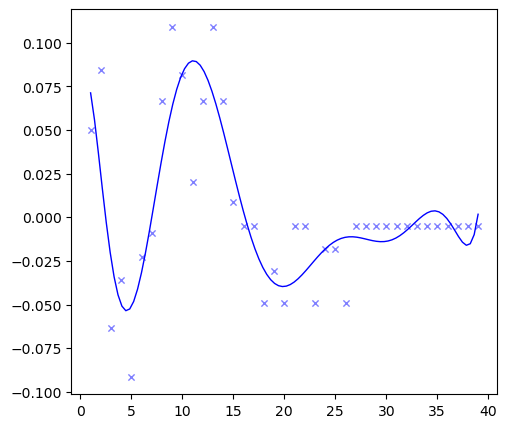

In [82]:
# import matplotlib.pyplot as plt
# x = np.array(range(1,40))
# y = np.array(pd_kappa_list)

# from scipy.interpolate import interp1d

# # Interpolation
# interp_func = interp1d(x, y, kind='slinear')  # 'cubic' for cubic spline interpolation
# x_smooth = np.linspace(1, 39, 500)
# y_smooth = interp_func(x_smooth)
# plt.plot(x_smooth, y_smooth, label='Smoothed Data', color='red')

# plt.plot(pd_kappa_list)

import matplotlib.pyplot as plt
import numpy as np

x = np.array(range(1,40))
y = np.array(pd_kappa_list) +0.05




plt.figure(figsize=(5.5, 5))
#---------------------------------------------------------
coefficients = np.polyfit(x, y, 9)
poly = np.poly1d(coefficients)

# Generate x values for the fitted curve
x_fit = np.linspace(min(x), max(x), 100)

plt.scatter(x, y, marker='x', color='blue', alpha=0.5, s=20, lw=1)
plt.plot(x_fit, poly(x_fit), label='Llama2-13b-SFT', color='blue', lw=1)


In [8]:
from evaluate import load
bertscore = load("bertscore")

bertscore_preference = []
for t0, t1, t2 in zip(selected_data['output_v0'], selected_data['output_v1'], selected_data['output_v2']):
    bs1 = bertscore.compute(predictions=[t1], references=[t0], lang="en")
    bs2 = bertscore.compute(predictions=[t2], references=[t0], lang="en")
    if bs1['f1'] > bs2['f1']:
        bertscore_preference.append(1)
    else:
        bertscore_preference.append(2)

bert_corr = cohen_kappa_score(human_preference, bertscore_preference)
print('bertscore kappa: ', bert_corr)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bertscore kappa:  0.15443522654754316


In [ ]:
# from metrics import calculate_positional_divergence

# calculate_positional_divergence(
#     predictions=selected_data['gpt_scores_unshuffled'],
#     references=xx,
#     num_class=8,
#     num_bins_default=10,
#     return_normalized_score=False, 
#     return_tensor=True
#     )

# Plot bin histogram 

In [1]:
from datasets import load_dataset
import numpy as np

news_train_path = '/home/yinhong/Documents/source/discourse_rl/data/news_discourse_preprocessed/test_data.jsonl'

news_data = load_dataset('json', data_files=news_train_path)['train']
news_data['discourse']

Found cached dataset json (/home/yinhong/.cache/huggingface/datasets/json/default-2d672e7e79b12036/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]

[[0, 2, 0, 0, 0, 0, 3, 3, 6, 3, 3, 3, 6, 3, 3, 2, 6, 6, 3, 4, 6, 6, 6, 6],
 [0, 5, 6, 0, 3, 6, 6, 6, 6, 3, 5, 3, 5, 6, 6, 3, 5, 3, 5, 6, 6, 6, 6, 6],
 [0, 5, 5, 4, 5, 5, 5, 5, 5, 3, 3, 5, 5],
 [0, 0, 3, 6, 6, 6, 2, 3, 6, 6, 6, 6, 6, 6, 5, 2],
 [0,
  3,
  3,
  3,
  5,
  3,
  6,
  6,
  6,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  6,
  0,
  5,
  3,
  4,
  4,
  3,
  4,
  5,
  3,
  3,
  6,
  4,
  6,
  3,
  6],
 [0, 0, 2, 3, 3, 3, 3, 4, 6, 0, 5, 5],
 [0,
  3,
  6,
  6,
  6,
  5,
  3,
  3,
  3,
  3,
  6,
  6,
  6,
  6,
  6,
  3,
  5,
  6,
  7,
  7,
  2,
  2,
  3,
  3,
  6,
  6,
  6,
  3,
  3,
  5,
  6],
 [0, 5, 2, 2, 2, 2, 3, 6, 2, 3, 3, 3, 3, 3, 3, 5],
 [0, 2, 3, 2, 6, 6, 6, 3, 5, 4, 3, 6, 6, 6, 3, 3],
 [0, 5, 6, 5, 2, 2, 6, 2, 3, 3, 5],
 [0, 6, 5, 4, 4, 5, 4, 6, 4, 3, 3, 3, 3],
 [0,
  0,
  3,
  2,
  5,
  6,
  4,
  4,
  6,
  4,
  4,
  7,
  7,
  7,
  6,
  3,
  3,
  5,
  5,
  6,
  5,
  6,
  3,
  5,
  3,
  6,
  3,
  5,
  6,
  6],
 [0, 6, 5, 3, 3, 5, 5, 5, 2, 5, 5, 6, 3, 3, 5, 3],
 [0, 3, 5, 6, 6, 3,

In [2]:

prediction_path = '/home/yinhong/Documents/source/discourse_rl/output/output-news-7b-2e-4-epo3.jsonl'
prediction_data = load_dataset('json', data_files=prediction_path)['train']
prediction_data

Found cached dataset json (/home/yinhong/.cache/huggingface/datasets/json/default-12819cbbb17b1651/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['input', 'instruction', 'output', 'discourse', 'prediction'],
    num_rows: 199
})

In [3]:
from metrics import sentence_splitter, predict_sentence_discourse
response_sentences = sentence_splitter(prediction_data["prediction"])
response_discourse = [predict_sentence_discourse(sentences) for sentences in response_sentences]


In [4]:
def get_bined_discourse(discourse, bin_num=5):
    bin_cnt, bin_values = np.histogram(range(len(discourse)), bins=bin_num)
    bined_discourse = [[] for _ in range(bin_num)]
    for idx in range(len(discourse)):
        bin_idx = np.digitize(idx, bin_values[:-1])-1
        bined_discourse[bin_idx].append(discourse[idx])
    return bined_discourse


def get_full_bined_discourse(discourse_list, bin_num=5):
    full_bined_discourse = [[] for _ in range(bin_num)]
    for discourse in discourse_list:
        bined_discourse = get_bined_discourse(discourse, bin_num)
        for idx in range(bin_num):
            full_bined_discourse[idx] += bined_discourse[idx]
    return full_bined_discourse

full_bined_discourse = get_full_bined_discourse(news_data['discourse'], bin_num=5)

full_bined_prediction_discourse = get_full_bined_discourse(response_discourse, bin_num=5)

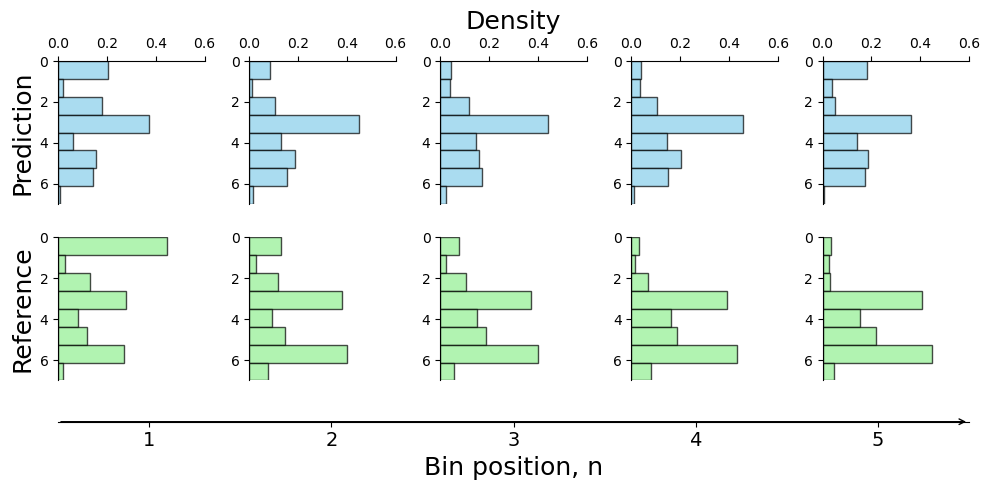

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

fontsize = 18
alpha = 0.7

# Create a 3x5 subplot with rotated histograms
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(3, 5, figure=fig, height_ratios=[18, 18, 1])

# Subplots for the top row
axs_top = [fig.add_subplot(gs[0, i]) for i in range(5)]
for i, data in enumerate(full_bined_prediction_discourse):
    axs_top[i].hist(data, bins=8, density=True, orientation='horizontal', color='skyblue', edgecolor='black', alpha=alpha)
    axs_top[i].invert_yaxis()
    axs_top[i].spines['top'].set_visible(True)
    axs_top[i].spines['right'].set_visible(False)
    axs_top[i].spines['bottom'].set_visible(False)
    axs_top[i].spines['left'].set_visible(True)
    axs_top[i].tick_params(axis='x', which='both', labelsize=10, bottom=False, top=True, labelbottom=False, labeltop=True)
    axs_top[i].set_xlim(0,0.6)
    axs_top[i].set_ylim(7,0)
    if i == 0:
        axs_top[i].set_ylabel('Prediction', fontsize=fontsize)
    if i ==2:
        axs_top[i].set_title('Density', fontsize=fontsize)

# Subplots for the middle row
axs_middle = [fig.add_subplot(gs[1, i]) for i in range(5)]
for i, data in enumerate(full_bined_discourse):
    axs_middle[i].hist(data, bins=8, density=True, orientation='horizontal', color='lightgreen', edgecolor='black', alpha=alpha)
    axs_middle[i].invert_yaxis()
    axs_middle[i].spines['top'].set_visible(False)
    axs_middle[i].spines['right'].set_visible(False)
    axs_middle[i].spines['bottom'].set_visible(False)
    axs_middle[i].spines['left'].set_visible(True)
    axs_middle[i].tick_params(axis='x', which='both', labelsize=10, bottom=False, top=False, labelbottom=False, labeltop=False)
    axs_middle[i].set_xlim(0,0.5)
    axs_middle[i].set_ylim(7,0)
    if i == 0:
        axs_middle[i].set_ylabel('Reference', fontsize=fontsize)

# Subplot at the bottom (only x-axis)
ax_bottom = fig.add_subplot(gs[2, :])
ax_bottom.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)


# Set the x tick positions
tick_positions = [1, 3, 5, 7, 9]
tick_labels = [1, 2, 3, 4, 5]
# axes.set_xticks(ticks, minor=False)

ax_bottom.set(xticks=tick_positions, xticklabels=tick_labels)
ax_bottom.tick_params(axis='x', which='both', labelsize=14)
ax_bottom.set_xlim(0,10)
ax_bottom.set_xlabel('Bin position, n', fontsize=fontsize)
ax_bottom.spines['top'].set_visible(False)
ax_bottom.spines['right'].set_visible(False)
ax_bottom.spines['bottom'].set_visible(True)
ax_bottom.spines['left'].set_visible(False)
ax_bottom.annotate('', xy=(10, 0), xytext=(0, 0), arrowprops=dict(arrowstyle='->', lw=1))

# Adjust layout and show the plot
plt.tight_layout(h_pad=2)

plt.show()


fig.savefig('positional_distribution.pdf', bbox_inches='tight')


# Plot PDD vs bin

In [ ]:
from datasets import load_dataset
import numpy as np
from metrics import sentence_splitter, predict_sentence_discourse, calculate_positional_divergence


In [109]:
# Predictions by llama 7b
prediction_path = '/home/yinhong/Documents/source/discourse_rl/output/output-news-7b-2e-4-epo2.jsonl'
prediction_data = load_dataset('json', data_files=prediction_path)['train']


# prediction_data['prediction']

Found cached dataset json (/home/yinhong/.cache/huggingface/datasets/json/default-a5a31dff53e152fe/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]

["AMR Corp. shareholders on Tuesday rejected two proposals that would have limited executive compensation at the company, which filed for bankruptcy protection in November 2011. The airline's board of directors had recommended that shareholders vote against both proposals. The first proposal would have capped annual compensation for executives at $5 million and the second would have given shareholders a nonbinding advisory vote on executive compensation each year. AMR is the parent company of American Airlines Group Inc. Shareholders also voted to approve the company's 2014 stock incentive plan, which provides for grants of restricted stock and stock options to eligible employees. In addition, shareholders approved the reappointment of Deloitte & Touche LLP as the company's independent registered public accounting firm for 2015. AMR filed for Chapter 11 bankruptcy protection in November 2011, citing high fuel prices and stiff competition from rivals such as Delta Air Lines Inc. and Uni

In [110]:
response_sentences = sentence_splitter(prediction_data["prediction"])
response_discourse = [predict_sentence_discourse(sentences) for sentences in response_sentences]

PDD_list_7b = []
for bin in range(1,30):
    div = calculate_positional_divergence(
        predictions=response_discourse, 
        references=news_data['discourse'],
        num_class=8,
        num_bins_default=bin,
        return_normalized_score=False,
        return_tensor=False
        )
    PDD_list_7b.append(div)

PDD_list_7b

[0.0764649247296061,
 0.10369581666015687,
 0.109185161810146,
 0.11317129698386384,
 0.12039708570678567,
 0.11848079361714757,
 0.13716655638296862,
 0.12958809399766352,
 0.14165183288949093,
 0.14044232926157113,
 0.14250861270573079,
 0.15169095164010177,
 0.18448530987997921,
 0.1653285634430298,
 0.192306298308914,
 0.1582669830885675,
 0.16735007768762525,
 0.2586131488952382,
 0.2596094435098603,
 0.2663909686336444,
 0.24258507708582683,
 0.2897093922899606,
 0.2630610690779568,
 0.29623812651164216,
 0.2983241787895857,
 0.3495920391513113,
 0.46026857536374605,
 0.43986819563360224,
 0.37691962970755416]

In [100]:
# Predictions by llama 13b

prediction_path = '/home/yinhong/Documents/source/discourse_rl/output/output-news13b-3e-4-epo2.jsonl'
prediction_data = load_dataset('json', data_files=prediction_path)['train']


Found cached dataset json (/home/yinhong/.cache/huggingface/datasets/json/default-f07a4c08bc5fcedb/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]

In [103]:

response_sentences = sentence_splitter(prediction_data["prediction"])
response_discourse = [predict_sentence_discourse(sentences) for sentences in response_sentences]


PDD_list_13b = []
for bin in range(1,30):
    div = calculate_positional_divergence(
        predictions=response_discourse, 
        references=news_data['discourse'],
        num_class=8,
        num_bins_default=bin,
        return_normalized_score=False,
        return_tensor=False
        )
    PDD_list_13b.append(div)

PDD_list_13b

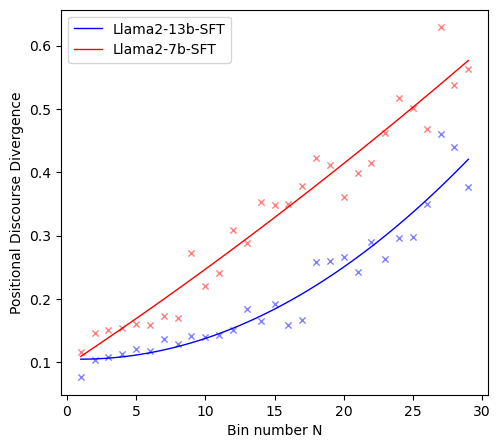

In [130]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(range(1,30))
y = np.array(PDD_list_7b)
y2 = np.array(PDD_list_13b)



plt.figure(figsize=(5.5, 5))
#---------------------------------------------------------
coefficients = np.polyfit(x, y, 2)
poly = np.poly1d(coefficients)

# Generate x values for the fitted curve
x_fit = np.linspace(min(x), max(x), 100)

plt.scatter(x, y, marker='x', color='blue', alpha=0.5, s=20, lw=1)
plt.plot(x_fit, poly(x_fit), label='Llama2-13b-SFT', color='blue', lw=1)
#---------------------------------------------------------
coefficients = np.polyfit(x, y2, 2)
poly = np.poly1d(coefficients)

# Generate x values for the fitted curve
x_fit = np.linspace(min(x), max(x), 100)

plt.scatter(x, y2, marker='x', color='red', alpha=0.5, s=20, lw=1)
plt.plot(x_fit, poly(x_fit), label='Llama2-7b-SFT', color='red', lw=1)

plt.xlabel('Bin number N')
plt.ylabel('Positional Discourse Divergence')

plt.legend()

plt.savefig('divergence_vs_bin.pdf', bbox_inches='tight')

